In [50]:
from typing import TypedDict, Annotated, Optional
from langgraph.graph import add_messages, StateGraph, END
from langchain_groq import ChatGroq
from dotenv import load_dotenv
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.checkpoint.memory import MemorySaver
from uuid import uuid4
import json



In [51]:
load_dotenv()

model = ChatGroq(model="llama-3.3-70b-versatile")

In [52]:
search_tool = TavilySearchResults(max_results= 4)

tools = [search_tool]

memory = MemorySaver()

In [53]:
llm_with_tools = model.bind_tools(tools=tools)

response = llm_with_tools.invoke("tell me Today's Mumbai weather")
print(response)

content='' additional_kwargs={'tool_calls': [{'id': 'call_ecxj', 'function': {'arguments': '{"query": "Mumbai weather today"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 284, 'total_tokens': 305, 'completion_time': 0.076363636, 'prompt_time': 0.024692373, 'queue_time': 0.053710677, 'total_time': 0.101056009}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3f3b593e33', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--d415e493-f376-49c4-90f9-86ece93dea55-0' tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Mumbai weather today'}, 'id': 'call_ecxj', 'type': 'tool_call'}] usage_metadata={'input_tokens': 284, 'output_tokens': 21, 'total_tokens': 305}


In [54]:
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage

class State(TypedDict):
    messages: Annotated[list, add_messages]

async def model(state: State):
    result = await llm_with_tools.ainvoke(state["messages"])
    return {
        "messages": [result], 
    }

async def tools_router(state: State):
    last_message = state["messages"][-1]

    if(hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0):
        return "tool_node"
    else: 
        return END
    
async def tool_node(state):
    """Custom tool node that handles tool calls from the LLM."""
    # Get the tool calls from the last message
    tool_calls = state["messages"][-1].tool_calls
    
    # Initialize list to store tool messages
    tool_messages = []
    
    # Process each tool call
    for tool_call in tool_calls:
        tool_name = tool_call["name"]
        tool_args = tool_call["args"]
        tool_id = tool_call["id"]
        
        # Handle the search tool
        if tool_name == "tavily_search_results_json":
            # Execute the search tool with the provided arguments
            search_results = await search_tool.ainvoke(tool_args)
            
            # Create a ToolMessage for this result
            tool_message = ToolMessage(
                content=str(search_results),
                tool_call_id=tool_id,
                name=tool_name
            )
            
            tool_messages.append(tool_message)
    
    # Add the tool messages to the state
    return {"messages": tool_messages}

graph_builder = StateGraph(State)

graph_builder.add_node("model", model)
graph_builder.add_node("tool_node", tool_node)
graph_builder.set_entry_point("model")

graph_builder.add_conditional_edges(
    "model",
    tools_router,
    {
        "tool_node": "tool_node",
        END: END
    }
)
graph_builder.add_edge("tool_node", "model")

graph = graph_builder.compile(checkpointer=memory)

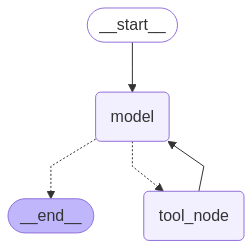

In [55]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

In [56]:
config ={
    "configurable" : {
        "thread_id" : 1
    }
}

response = await graph.ainvoke({
    "messages" : [HumanMessage(content = "Hi I'm Sahil")]
}, config = config)

response

{'messages': [HumanMessage(content="Hi I'm Sahil", additional_kwargs={}, response_metadata={}, id='e1bd1b75-a1f6-4111-a6f3-4c05de32d435'),
  AIMessage(content="Hello Sahil, it's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 283, 'total_tokens': 310, 'completion_time': 0.098181818, 'prompt_time': 0.025642229, 'queue_time': 0.05366670899999999, 'total_time': 0.123824047}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3f3b593e33', 'finish_reason': 'stop', 'logprobs': None}, id='run--2a46f652-03ee-4810-a8d4-8c1e52c728dd-0', usage_metadata={'input_tokens': 283, 'output_tokens': 27, 'total_tokens': 310})]}

In [57]:
response = await graph.ainvoke({
    "messages" : [HumanMessage(content = "Whats my name")]
}, config = config)

response

{'messages': [HumanMessage(content="Hi I'm Sahil", additional_kwargs={}, response_metadata={}, id='e1bd1b75-a1f6-4111-a6f3-4c05de32d435'),
  AIMessage(content="Hello Sahil, it's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 283, 'total_tokens': 310, 'completion_time': 0.098181818, 'prompt_time': 0.025642229, 'queue_time': 0.05366670899999999, 'total_time': 0.123824047}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3f3b593e33', 'finish_reason': 'stop', 'logprobs': None}, id='run--2a46f652-03ee-4810-a8d4-8c1e52c728dd-0', usage_metadata={'input_tokens': 283, 'output_tokens': 27, 'total_tokens': 310}),
  HumanMessage(content='Whats my name', additional_kwargs={}, response_metadata={}, id='3314553f-95be-4ffd-8f94-2e6e6c4a8ad1'),
  AIMessage(content='Your name is Sahil.', additional_kwargs={}, response_metadata={'token_usage': {'comp

In [58]:
response = await graph.ainvoke({
    "messages" : [HumanMessage(content = "Thanks")]
}, config = config)

response

{'messages': [HumanMessage(content="Hi I'm Sahil", additional_kwargs={}, response_metadata={}, id='e1bd1b75-a1f6-4111-a6f3-4c05de32d435'),
  AIMessage(content="Hello Sahil, it's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 283, 'total_tokens': 310, 'completion_time': 0.098181818, 'prompt_time': 0.025642229, 'queue_time': 0.05366670899999999, 'total_time': 0.123824047}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3f3b593e33', 'finish_reason': 'stop', 'logprobs': None}, id='run--2a46f652-03ee-4810-a8d4-8c1e52c728dd-0', usage_metadata={'input_tokens': 283, 'output_tokens': 27, 'total_tokens': 310}),
  HumanMessage(content='Whats my name', additional_kwargs={}, response_metadata={}, id='3314553f-95be-4ffd-8f94-2e6e6c4a8ad1'),
  AIMessage(content='Your name is Sahil.', additional_kwargs={}, response_metadata={'token_usage': {'comp

In [59]:
response = await graph.ainvoke({
    "messages" : [HumanMessage(content = "When is the next ipl match of 2025")]
}, config = config)

response

{'messages': [HumanMessage(content="Hi I'm Sahil", additional_kwargs={}, response_metadata={}, id='e1bd1b75-a1f6-4111-a6f3-4c05de32d435'),
  AIMessage(content="Hello Sahil, it's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 283, 'total_tokens': 310, 'completion_time': 0.098181818, 'prompt_time': 0.025642229, 'queue_time': 0.05366670899999999, 'total_time': 0.123824047}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3f3b593e33', 'finish_reason': 'stop', 'logprobs': None}, id='run--2a46f652-03ee-4810-a8d4-8c1e52c728dd-0', usage_metadata={'input_tokens': 283, 'output_tokens': 27, 'total_tokens': 310}),
  HumanMessage(content='Whats my name', additional_kwargs={}, response_metadata={}, id='3314553f-95be-4ffd-8f94-2e6e6c4a8ad1'),
  AIMessage(content='Your name is Sahil.', additional_kwargs={}, response_metadata={'token_usage': {'comp

In [60]:
async for event in graph.astream_events({
    "messages": [HumanMessage(content="When is the next spacex launch?")],
}, config=config, version="v2"):
    print(event)

{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='When is the next spacex launch?', additional_kwargs={}, response_metadata={})]}}, 'name': 'LangGraph', 'tags': [], 'run_id': '95e54b35-9ad6-4f3d-80f8-70494be84932', 'metadata': {'thread_id': 1}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content="Hi I'm Sahil", additional_kwargs={}, response_metadata={}, id='e1bd1b75-a1f6-4111-a6f3-4c05de32d435'), AIMessage(content="Hello Sahil, it's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 283, 'total_tokens': 310, 'completion_time': 0.098181818, 'prompt_time': 0.025642229, 'queue_time': 0.05366670899999999, 'total_time': 0.123824047}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3f3b593e33', 'finish_reason': 'stop', 'logprobs': None}, id='run--2a46f652-03ee-48

In [61]:
async for event in graph.astream_events({
    "messages": [HumanMessage(content="When is the next ipl match of 2025")],
}, config=config, version="v2"):
    if event["event"] == "on_chat_model_stream":
        print(event["data"]["chunk"].content, end="",flush= True)

The next IPL match of 2025 is on May 16, with Royal Challengers Bengaluru facing Kolkata Knight Riders at the Sawai Mansingh Stadium in Jaipur, starting at 2:00 PM GMT / 7:30 PM LOCAL.

In [62]:
async for event in graph.astream_events({
    "messages": [HumanMessage(content="Tell me the name of the two lady officer who was backbons of Sindoor Mission")],
}, config=config, version="v2"):
    if event["event"] == "on_chat_model_stream":
        print(event["data"]["chunk"].content, end="",flush= True)

The two lady officers who were the backbone of the Sindoor Mission are Wing Commander Vyomika Singh and Colonel Sofiya Qureshi.